In [690]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

from models.CNN import CNNForecaster

from utils import reverse_forecast

In [691]:
model = CNNForecaster((4, 10), (4, 1), 2, 0.0, 32)
model.load_state_dict(torch.load('saved_models/cnn_forecaster_checkpoint.pt', map_location=torch.device('cpu')))
model.eval()

CNNForecaster(
  (embedding): Linear(in_features=40, out_features=320, bias=False)
  (conv_layers): ModuleList(
    (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (conv_seq): Sequential(
    (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (fc): Linear(in_features=320, out_features=4, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [692]:
hist = torch.tensor(np.load('data/box_testing_data/x_train.npy'), dtype=torch.float32).detach()
truth = torch.tensor(np.load('data/box_testing_data/y_train.npy'), dtype=torch.float32).detach()

# IDX = np.random.randint(0, hist.shape[0])
IDX = 33
print(IDX)

hist_x = hist[IDX:IDX+1, :, :]
truth_y = truth[IDX:IDX+1, :, :]

33


In [693]:
def interpolate_positions(realign_hist, deg=2):
    
    x_fit = np.polyfit(realign_hist[:, 0], realign_hist[:, 1], deg)
    y_fit = np.polyfit(realign_hist[:, 0], realign_hist[:, 2], deg)
    w_fit = np.polyfit(realign_hist[:, 0], realign_hist[:, 3], deg)
    h_fit = np.polyfit(realign_hist[:, 0], realign_hist[:, 4], deg)
    x_fun, y_fun, w_fun, h_fun = np.poly1d(x_fit), np.poly1d(y_fit), np.poly1d(w_fit), np.poly1d(h_fit)
    
    positions = np.zeros((4, 10))

    positions[0, :] = [x_fun(t) for t in range(int(realign_hist[-2, 0])+1, int(realign_hist[-1, 0]))]
    positions[1, :] = [y_fun(t) for t in range(int(realign_hist[-2, 0])+1, int(realign_hist[-1, 0]))]
    positions[2, :] = [w_fun(t) for t in range(int(realign_hist[-2, 0])+1, int(realign_hist[-1, 0]))]
    positions[3, :] = [h_fun(t) for t in range(int(realign_hist[-2, 0])+1, int(realign_hist[-1, 0]))]
    
    return torch.tensor(positions.astype(np.float32)).unsqueeze(0)

# test_tensor = torch.randint((3, 5))
# print(interpolate_positions(test_tensor).shape)

In [694]:
from datetime import datetime as dt

# hist_x = torch.randn((1, 4, 10)).to('cpu')
# realign_coors = np.hstack(([[0], [9]], hist_x.detach().numpy()[0, :, [0, 9]]))
start = dt.now()

# for i in range(10):
#     pred = torch.round(model(hist_x[:, :, -10:]))
#     hist_x = torch.cat((hist_x, pred.unsqueeze(-1)), dim=-1)

# # x, y, w, h = truth_y.numpy()[0, :, 9]
# # new_adj = np.array([[20, x, y, w, h]])
# # realign_coors = np.append(realign_coors, new_adj , axis=0)

# future_time_step = 20
# future = truth_y[:, :, future_time_step-1].unsqueeze(-1)

# with torch.no_grad():
#     y_fit = torch.round(reverse_forecast(hist_x[:, :, :10],
#                                         list(range(10)),
#                                         future,
#                                         future_time_step,
#                                         deg=4))

# for i in range(10):
#     pred = torch.round(model(y_fit[:, :, -10:]))
#     y_fit = torch.cat((y_fit, pred.unsqueeze(-1)), dim=-1)

end = dt.now()

print("Time Taken:", end - start)



Time Taken: 0:00:00.000072


In [700]:
def run_model(model, history, truth):
    model.eval()
    with torch.no_grad():
        predictions = torch.zeros_like(truth)
        for iteration in range(truth.shape[2] // 10):
            pred_series = torch.zeros((1, 4, 10))
            for i in range(10):
                input_hist = torch.cat((history[:, :, -(10-i):], pred_series[:, :, :i]), dim=-1)
                pred = torch.round(model(input_hist))
                pred_series[:, :, i] = pred
            
            predictions[:, :, (iteration*10):((iteration+1)*10)] = pred_series

            fts = 10 * (iteration + 1)
            future = truth[:, :, fts-1].unsqueeze(-1)
            
            interpolated = reverse_forecast(history[:, :, -10:],
                                            list(range(10)),
                                            future,
                                            19, deg=3)
            interpolated = torch.round(interpolated)
            history = torch.cat((history, interpolated), dim=-1)
        
        return predictions

start = dt.now()
predictions = run_model(model, hist_x, truth_y)
end = dt.now()
print("Time Taken:", end - start)

Time Taken: 0:00:00.262125


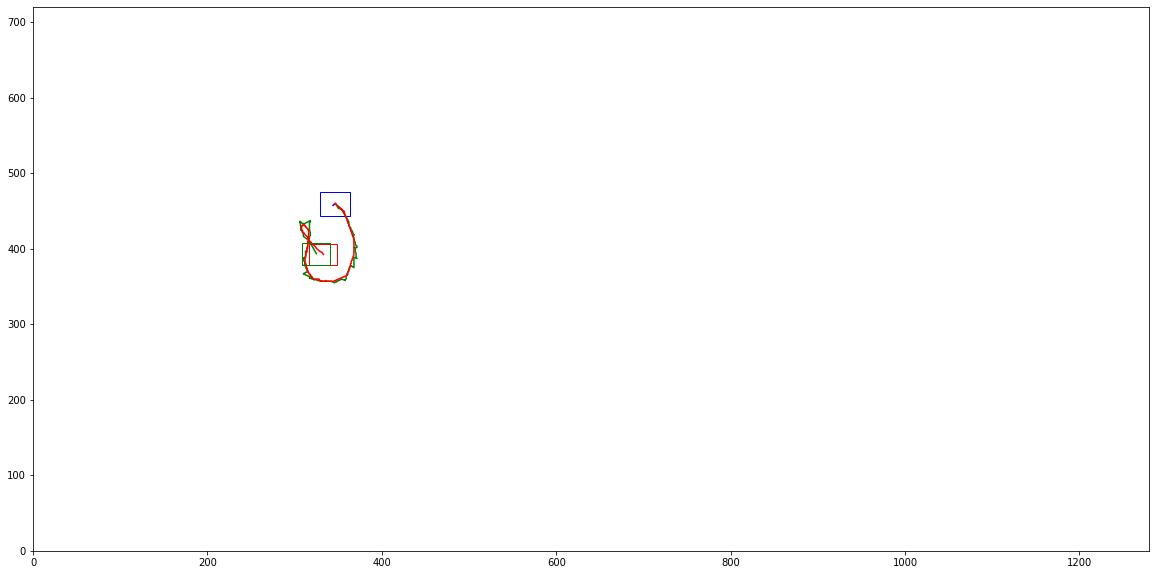

In [701]:
from matplotlib.patches import Rectangle

def midpoint(arr):
    arr = arr[0, :, :]
    x = arr[0] + .5 * arr[2]
    y = arr[1] + .5 * arr[3]
    return np.array([x, y])

hist_mid = midpoint(hist_x.detach().numpy())
predictions_mid = midpoint(predictions.detach().numpy())
truth_mid = midpoint(truth_y.detach().numpy())

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(predictions_mid[0], predictions_mid[1], 'g-', label='Predictions')
ax.plot(hist_mid[0], hist_mid[1], 'b-', label='History')
ax.plot(truth_mid[0], truth_mid[1], 'r-', label='Truth')

ax.add_patch(Rectangle((hist_x[0, 0, -1], hist_x[0, 1, -1]), hist_x[0, 2, -1], hist_x[0, 3, -1], fill=False, edgecolor='blue'))
ax.add_patch(Rectangle((truth_y[0, 0, -1], truth_y[0, 1, -1]), truth_y[0, 2, -1], truth_y[0, 3, -1], fill=False, edgecolor='red'))
ax.add_patch(Rectangle((predictions[0, 0, -1], predictions[0, 1, -1]), predictions[0, 2, -1], predictions[0, 3, -1], fill=False, edgecolor='green'))

ax.set_xlim(0, 1280)
ax.set_ylim(0, 720)
plt.show()

In [705]:
x_test = torch.tensor(np.load('data/test_video/x_test.npy'), dtype=torch.float32).detach()
y_test = torch.tensor(np.load('data/test_video/y_test.npy'), dtype=torch.float32).detach()

Time Taken: 0:00:01.883378


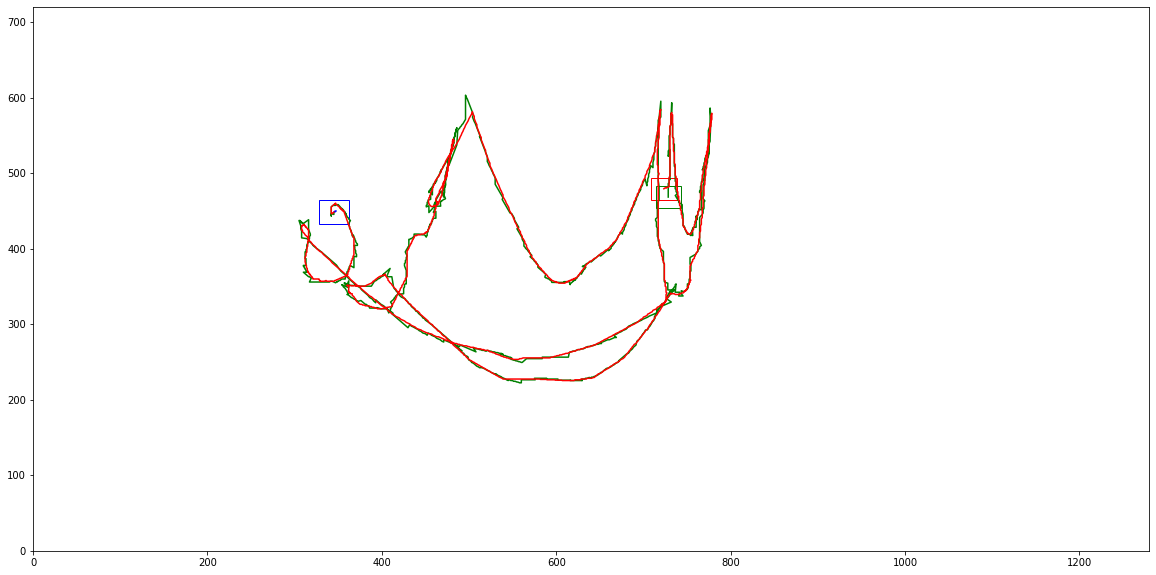

In [706]:
start = dt.now()
predictions = run_model(model, x_test, y_test)
end = dt.now()
print("Time Taken:", end - start)

hist_mid = midpoint(x_test.detach().numpy())
predictions_mid = midpoint(predictions.detach().numpy())
truth_mid = midpoint(y_test.detach().numpy())

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(predictions_mid[0], predictions_mid[1], 'g-', label='Predictions')
ax.plot(hist_mid[0], hist_mid[1], 'b-', label='History')
ax.plot(truth_mid[0], truth_mid[1], 'r-', label='Truth')

ax.add_patch(Rectangle((x_test[0, 0, -1], x_test[0, 1, -1]), x_test[0, 2, -1], x_test[0, 3, -1], fill=False, edgecolor='blue'))
ax.add_patch(Rectangle((y_test[0, 0, -1], y_test[0, 1, -1]), y_test[0, 2, -1], y_test[0, 3, -1], fill=False, edgecolor='red'))
ax.add_patch(Rectangle((predictions[0, 0, -1], predictions[0, 1, -1]), predictions[0, 2, -1], predictions[0, 3, -1], fill=False, edgecolor='green'))

ax.set_xlim(0, 1280)
ax.set_ylim(0, 720)
plt.show()

In [708]:
"""
Create a video file of the detected objects
"""
import cvlib as cv
import cv2
from tqdm.notebook import tqdm

curr_img = cv2.imread(f'data/NFS/basketball_1/240/basketball_1/00001.jpg')
# bbox, label, conf = cv.detect_common_objects(curr_img, confidence=0.1, model='yolov4-tiny')
height, width, _ = curr_img.shape
print(f'height: {height}, width: {width}')
writer = cv2.VideoWriter('test_video_out.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

for i in tqdm(range(1, 2240)):
    curr_img = cv2.imread(f'data/NFS/basketball_1/240/basketball_1/{i:05d}.jpg')
    if i < 10:
        bbox = [x_test[0, :, i-1].detach().numpy().flatten()]
        label = ['actual']
        conf = [1]
    if i > 10:
        bbox = [predictions[0, :, i-1].detach().numpy().flatten(),
                y_test[0, :, i-1].detach().numpy().flatten()]
        label = ['predicted', 'truth']
        conf = [1, 1]
    output_image = cv.draw_bbox(curr_img, bbox, label, conf)
    writer.write(output_image)

writer.release()

AlreadyExistsError: Another metric with the same name already exists.

In [699]:
def average_displacement_loss(y_pred, y):
    """
    Compute the average displacement loss from two tensors
    """
    return torch.mean(torch.norm(y_pred - y, 2, dim=1))

average_displacement_loss(predictions, truth_y)

RuntimeError: The size of tensor a (2239) must match the size of tensor b (240) at non-singleton dimension 2

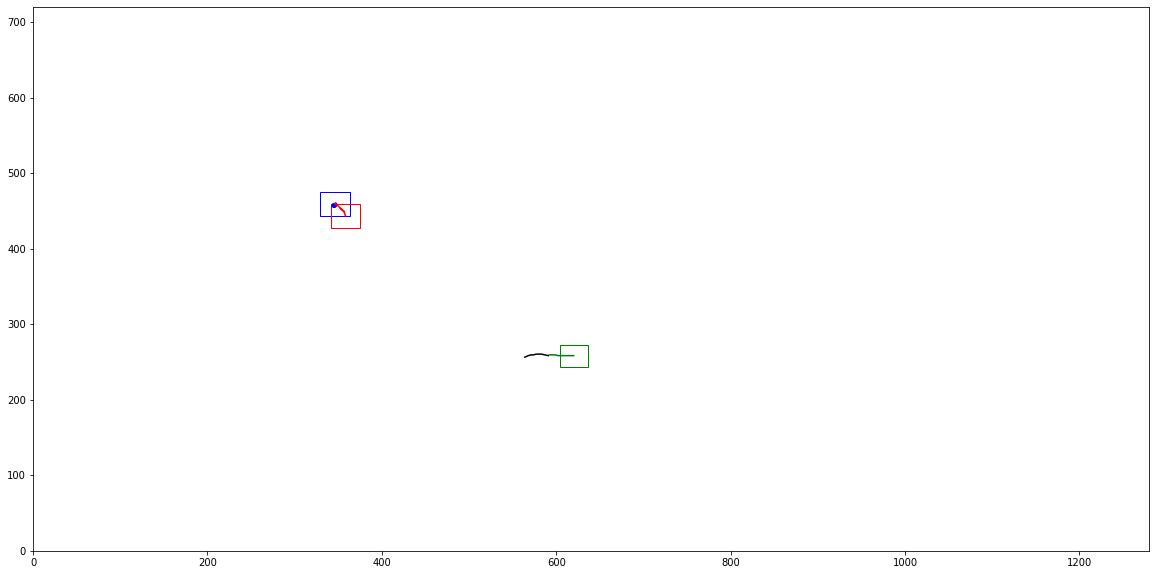

In [ ]:
from matplotlib.patches import Rectangle

x_test = hist[IDX:IDX+1, :, :].detach()
y_test = truth[IDX:IDX+1, :, :31].detach()
y_pred = hist_x[:, :, 10:20].detach()
pred2 = y_fit[:, :, 10:].detach()
y_fitted = y_fit[:, :, :10].detach()

def midpoint(arr):
        arr = arr[0]
        x = arr[0] + .5 * arr[2]
        y = arr[1] + .5 * arr[3]
        return np.array([x.numpy(), y.numpy()])
    
x_mid = midpoint(x_test)
y_test_mid = midpoint(y_test)
y_pred_mid = midpoint(y_pred)
y_pred2_mid = midpoint(pred2)
y_fit_mid = midpoint(y_fitted)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(x_mid[0], x_mid[1], 'b.-')
ax.plot(y_test_mid[0], y_test_mid[1], 'r-')
ax.plot(y_pred_mid[0], y_pred_mid[1], 'g-')
ax.plot(y_pred2_mid[0], y_pred2_mid[1], 'g-')
ax.plot(y_fit_mid[0], y_fit_mid[1], 'k-')

ax.add_patch(Rectangle((x_test[0, 0, -1], x_test[0, 1, -1]), x_test[0, 2, -1], x_test[0, 3, -1], fill=False, edgecolor='blue'))
ax.add_patch(Rectangle((y_test[0, 0, -1], y_test[0, 1, -1]), y_test[0, 2, -1], y_test[0, 3, -1], fill=False, edgecolor='red'))
# ax.add_patch(Rectangle((y_pred[0, 0, -1], y_pred[0, 1, -1]), y_pred[0, 2, -1], y_pred[0, 3, -1], fill=False, edgecolor='green'))
ax.add_patch(Rectangle((pred2[0, 0, -1], pred2[0, 1, -1]), pred2[0, 2, -1], pred2[0, 3, -1], fill=False, edgecolor='green'))
# ax.add_patch(Rectangle((y_fitted[0, 0, -1], y_fitted[0, 1, -1]), y_fitted[0, 2, -1], y_fitted[0, 3, -1], fill=False, edgecolor='black'))

ax.set_xlim(0, 1280)
ax.set_ylim(0, 720)
plt.show()

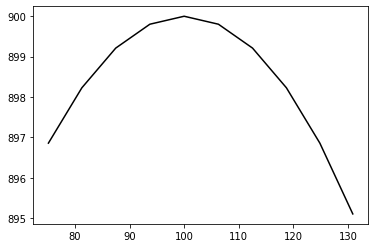

In [ ]:
# np array of x, y coordinates in a circle

circle = np.array([[np.cos(2*np.pi*i/100) for i in range(100)],
                   [np.sin(2*np.pi*i/100) for i in range(100)],
                   [10] * 100,
                   [20] * 100])

circle *= 100
circle[0] += 100
circle[1] += 800

circle = circle[:, 20:30]

plt.plot(circle[0, :], circle[1, :], 'k-')

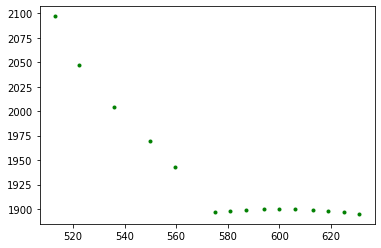

In [ ]:
circle_test = torch.round(torch.tensor(circle.astype(np.float32)).unsqueeze(0))

with torch.no_grad():
    for i in range(5):
        pred = torch.round(model(circle_test[:, :, -10:]))
        circle_test = torch.cat((circle_test, pred.unsqueeze(-1)), dim=-1)

    mid = midpoint(circle_test)
    plt.plot(mid[0], mid[1], 'g.')